<a href="https://colab.research.google.com/github/ExCaLBBR/ExCaLBBR_Projects/blob/main/SocioenvironmentalGeometry/code/ConceptGeo_AnalysisPipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Concept Geometry analysis pipeline
For PNAS manuscript: <br>
Authors: <b>Roberto Vargas; Timothy Verstynen </b><br>
Codebook created by: <b>Roberto Vargas </b><br>
Acknowledgements: <b>Nahom Mossazghi</b><br>
<br>
<b>Pipeline includes:</b><br>
*   Data restructuring: Sorting accoring to word list
*   Regression predicting pair edged using: <i>Race; Gender; Income; Age; NewsBias</i>
*   Mediation analysis:


<br>
<br>

In [1]:
#@title Install dependancies
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import networkx as nx
from scipy import stats
from itertools import combinations
from itertools import compress
import math
import statsmodels.formula.api as smf
import statsmodels as sm
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import csv
from tqdm import tqdm
import networkx as nx
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif
from scipy.stats import ttest_ind
import requests
import geopandas as gpd
!pip install census --quiet
!pip install us --quiet
from census import Census
from us import states
import os

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 5.9 MB/s eta 0:00:00


In [2]:
#@title Define utility functions
def weightedHeatmap(PairData, words, PlotHM, Title):

    '''
    Restructure RT into matrix data structure

    '''

    Wmat = np.zeros((len(words),len(words)))
    t = 0
    z = 0

    for i in range(len(words)):
        for j in range(len(words)):

            if i == j:
                Wmat[i,j] = np.NaN

            elif j > i:
                Wmat[i,j] = PairData[t]
                Wmat[j,i] = PairData[t]
                t += 1


    if PlotHM == 1:
        plt.title(Title)
        plt.imshow(Wmat,  cmap='RdBu', vmin=-7, vmax=7)
        plt.colorbar()
        plt.xticks(range(len(words)), words, rotation='vertical')
        plt.yticks(range(len(words)), words)
        plt.show()

    return Wmat

def ccbi_randperm(ntimes, nperm):

    '''
      p = ccbi_randperm(nitems,nperm)
      Parameters: number of items, number of random permutations
      Output: a matrix with nperm rows;
      Each row is an index of permuted item positions.

      returns a matrix (n,nitems)
      each row is a random permutation of nitems (labelled 1:nitems)
      produces n such permutations
      the random seed is changed at every call

    '''

    p = np.zeros((nperm, ntimes))
    for i in range(nperm):
        p[i,:] = np.random.permutation(ntimes)

    return p


def splitHalf_Reliability(dat, perm):
    """
    Compute the reliability within a measure
    This analysis splits the data into 2 halfs and then averages the similarity structure
    This analysis is repeated

    """
    pSplit = ccbi_randperm(dat.shape[1], perm)

    rho = []
    for p in range(perm):
        # Split data
        if dat.shape[1] % 2 == 0:  # is even
            frstHalf = dat.iloc[:, pSplit[p, :(pSplit.shape[1]//2)]]
            scndHalf = dat.iloc[:, pSplit[p, (pSplit.shape[1]//2):]]

        elif dat.shape[1] % 2 == 1:  # is odd
            frstHalf = dat.iloc[:, pSplit[p, :int(np.floor(pSplit.shape[1]/2))]]
            scndHalf = dat.iloc[:, pSplit[p, int(np.ceil(pSplit.shape[1]/2)):]]
        # Avg dist of each half
        avgFrstHalf = frstHalf.mean(axis=1)
        avgScndHalf = scndHalf.mean(axis=1)

        # Correlate halves
        rhoI = np.corrcoef(avgFrstHalf, avgScndHalf)[0,1]

        rho.append(rhoI)

    rho = np.mean(rho)

    return rho


def regPairDiff(X, Y, perm):

    '''

    Predict pair differences among a X in Y
 	X is vector or matrix of variables used to predict Y
 	Y is a continuous vector
 	perm is the number of permutations used to compare against the observed beta
  Dimensions of X and Y should all align

    '''

    # Generate the permutations
    pComb = ccbi_randperm(X.shape[0],perm)

    # Generate constant
    con = np.ones(X.shape[0])
    con = con.reshape(con.shape[0], 1)

    # Estimate observed beta
    xModel = np.concatenate((con, X), axis=1)
    betaObs, _, _, _ = np.linalg.lstsq(xModel.astype('float'), Y, rcond=None)

    betaPerm = []

    for p in range(perm):
        pCombi = pComb.astype(int)
        yPerm = Y[pCombi[p,:]]
        bPerm, _, _, _ = np.linalg.lstsq(xModel.astype('float'), yPerm, rcond=None)
        betaPerm.append(bPerm)

    betaPerm = pd.DataFrame(betaPerm)

    pval =[]
    for b in range(len(betaObs)):
      if betaObs[b] > 0:
        nBbeyond =  len(np.where(np.array(betaPerm[b]) > betaObs[b])[0])
        pb = nBbeyond/perm
        pval.append(pb)
      elif betaObs[b] < 0:
        nBbeyond = len([x for x in np.array(betaPerm[b]) if x < betaObs[b]])
        pb = nBbeyond/perm
        pval.append(pb)

      else:
        raise ValueError('observed beta is exactly equal to 0')

    return betaObs, pval, betaPerm


def mediation(x, m, y):
  '''
    Predict pair differences among a X in Y and the extent which this effect is mediated by m
 	X is vector used to predict Y
  m is a mediator
 	Y is a continuous vector
  '''
  import statsmodels.api as sm
  #Test effect of X on Y
  X = pd.DataFrame({'Intercept':np.ones(len(x)),'X':x})
  lm1 = sm.OLS(y,X).fit()
  ec = lm1.params[1] # save total effect c to ec

  #Test effect of X on M
  lm2 = sm.OLS(m,X).fit()
  ea = lm2.params[1] # Save the effect of X on M, a, to ea
  sea = lm2.bse[1]

  #Test effect of X and M on Y
  X['M'] = m
  lm3 = sm.OLS(y,X).fit()
  ecq,eb = lm3.params[1:3]
  seb = lm3.bse[2]

  toteff = ec # Total effect
  XM = ea #coef from x to m
  MY = eb #coef from m to y
  XMse = sea #standard error from x to m
  MYse = seb #standard error from m to y
  medeff = ea*eb #Indirect mediated effect
  direff = ecq #Direct effect
  sumeff = medeff + direff #sum of effect
  return toteff, medeff, direff, sumeff, XM, MY, XMse, MYse


def mediationPerm(x, m, y, perm):
  import statsmodels.api as sm
  '''
    Predict pair differences among a X in Y and the extent which this effect is mediated by m
 	X is vector used to predict Y
  m is a mediator
 	Y is a continuous vector
 	perm is the number of permutations used to compare against the observed beta
  Dimensions of X, m, and Y should all align
  '''
  pComb = ccbi_randperm(len(X),perm)
  toteff_obs, medeff_obs, direff_obs, sumeff_obs, XM_obs, MY_obs, XMse_obs, MYse_obs = mediation(x, m, y)
  t_obs, _ = sobel_test(XM_obs, MY_obs, XMse_obs, MYse_obs)

  toteff_perm = []
  medeff_perm = []
  direff_perm = []
  sumeff_perm = []
  medt_perm = []

  for p in range(perm):
      pCombi = pComb.astype(int)
      yPerm = y[pCombi[p,:]]
      toteff, medeff, direff, sumeff, XM, MY, XMse, MYse = mediation(x, m, yPerm)
      t_perm, _ = sobel_test(XM, MY, XMse, MYse)
      toteff_perm.append(toteff)
      medeff_perm.append(medeff)
      direff_perm.append(direff)
      sumeff_perm.append(sumeff)
      medt_perm.append(t_perm)

  # toteff_perm = pd.DataFrame(toteff_perm)
  # medeff_perm = pd.DataFrame(medeff_perm)
  # direff_perm = pd.DataFrame(direff_perm)
  # sumeff_perm = pd.DataFrame(sumeff_perm)

  pval_tot = []
  pval_med = []
  pval_dir = []
  pval_sum = []
  pval_sobelT = []

  #Determine sig for total effect
  if toteff_obs > 0:
    nBbeyond =  len(np.where(toteff_perm > toteff_obs)[0])
    pb = nBbeyond/perm
    pval_tot.append(pb)
  elif toteff_obs < 0:
    nBbeyond = len([x for x in toteff_perm if x < toteff_obs])
    pb = nBbeyond/perm
    pval_tot.append(pb)
  else:
    raise ValueError('observed beta is exactly equal to 0')

  #Determine sig for med effect
  if medeff_obs > 0:
    nBbeyond =  len(np.where(medeff_perm > medeff_obs)[0])
    pb = nBbeyond/perm
    pval_med.append(pb)
  elif medeff_obs < 0:
    nBbeyond = len([x for x in medeff_perm if x < medeff_obs])
    pb = nBbeyond/perm
    pval_med.append(pb)
  else:
    raise ValueError('observed beta is exactly equal to 0')

  #Determine sig for dir effect
  if direff_obs > 0:
    nBbeyond =  len(np.where(np.array(direff_perm) > direff_obs)[0])
    pb = nBbeyond/perm
    pval_dir.append(pb)
  elif direff_obs < 0:
    nBbeyond = len([x for x in direff_perm if x < direff_obs])
    pb = nBbeyond/perm
    pval_dir.append(pb)
  else:
    raise ValueError('observed beta is exactly equal to 0')

  #Determine sig for sum of effect
  if sumeff_obs > 0:
    nBbeyond =  len(np.where(sumeff_perm > sumeff_obs)[0])
    pb = nBbeyond/perm
    pval_sum.append(pb)
  elif sumeff_obs < 0:
    nBbeyond = len([x for x in sumeff_perm if x < sumeff_obs])
    pb = nBbeyond/perm
    pval_sum.append(pb)
  else:
    raise ValueError('observed beta is exactly equal to 0')

  #Test t effect from Sobel test
  if t_obs > 0:
    nTbeyond = len(np.where(medt_perm > t_obs)[0])
    pt = nTbeyond/perm
    pval_sobelT.append(pt)
  elif t_obs < 0:
    nTbeyond = len([x for x in medt_perm if x < t_obs])
    pt = nTbeyond/perm
    pval_sobelT.append(pt)
  else:
    raise ValueError('observed t is exactly equal to 0')


  ObsEff = pd.DataFrame({'TotEff':toteff_obs,'MedEff':medeff_obs, 'DirEff':direff_obs, 'SumEff':sumeff_obs, 'SobelT':t_obs},index=[0])
  pval = pd.DataFrame({'Totpval':pval_tot,'Medpval':pval_med, 'Dirpval':pval_dir, 'Sumpval':pval_sum, 'SobelTpval':pval_sobelT},index=[0])
  return ObsEff, pval


def sobel_test(a, b, se_a, se_b):
    '''
    Sobel test for significance of mediation

    Args:
        a: coefficient from X to mediator variable, M
        b: coefficient from M to Y
        se_a: Standard error of A
        se_b: Standard error fo B

    Returns:
        t: Sobel's test statistic
        pval : Two-tailed probability assuming normal distribution
    '''

    SE = np.sqrt( (a**2)*(se_a**2) + (b**2)*(se_b**2))
    t = (a*b) / SE
    n = 100000000
    pval = stats.t.sf(np.abs(t), n-1)*2
    return t, pval

In [3]:
#@title Clean up Dataframes mask out participants who didn't complete all parts of session
#Data path
path = 'https://github.com/ExCaLBBR/ExCaLBBR_Projects/raw/main/SocioenvironmentalGeometry/'

# Load Demographic PRaM data
datDemo = pd.read_csv (path + 'data/demographic.csv', header=1)
datPRaM = pd.read_csv (path + 'data/df_taskPRaM.csv', header=0)
pairLab = pd.read_csv (path + 'data/PRaM_pairLabels.csv', header=None)
news = pd.read_csv (path + 'data/df_News_coded.csv', header=1)

#remove misc row and incomplete sessions
datDemo = datDemo.drop(labels=0, axis=0)
datDemo = datDemo.reset_index(drop=True)
datDemo['Question Key'] = [sub[: -2] for sub in datDemo['Question Key']]
datPRaM = datPRaM.drop(['Participant Private ID'], axis=1)
datPRaM = datPRaM.reset_index(drop=True)
news = news.drop(labels=0, axis=0)
news = news.reset_index(drop=True)

#Identify participants who did not complete all measures
lst1 = datDemo['Question Key']
lst2 = news['Question Key']
exPart = list(set(lst1) - set(lst2))
mask = datDemo['Question Key'].str.contains(exPart[0], na=True) #If the number of participants to exclude exceeds 1 you will need a for loop
datDemo = datDemo[~mask]
datPRaM = datPRaM[~mask]

#reset index just in case
datDemo = datDemo.reset_index(drop=True)
datPRaM = datPRaM.reset_index(drop=True)
news = news.reset_index(drop=True)

#Sort pairs accoring to prefered combination
words = ['police', 'firefighter', 'neighbors(yours)', 'conservatives(political)', 'liberals(political)', 'healthcare', 'voting', 'immigration', 'religion', 'science', 'anger', 'fear', 'joy', 'love', 'sadness', 'trust']
combinations_list = [list(c) for c in combinations(words, 2)]

# re-organize the dataframe according to the word combination
PairLabel = []
x = []                  #index orders are saved as list
for i in range(len(combinations_list)):

    # Extract pair rating
    idx0 = pairLab[pairLab.iloc[:,1].str.contains(combinations_list[i][0].replace('(', r'\(').replace(')', r'\)'))].index
    idx1 = pairLab[pairLab.iloc[:,2].str.contains(combinations_list[i][1].replace('(', r'\(').replace(')', r'\)'))].index
    pIndx = idx0.intersection(idx1)

    # Extract pair label
    PairLabeli = combinations_list[i][0] + '-' + combinations_list[i][1]
    PairLabel.append(PairLabeli)
    x.append(pIndx[0])

# Pair label rating
datPRaM_conSort = datPRaM.iloc[:,x]
datPRaM_conSort = datPRaM_conSort.rename(columns=dict(zip(datPRaM_conSort.columns, PairLabel)))
PairLabel = pd.DataFrame(PairLabel)

In [4]:
#@title Subset participants by those who have complete data
#Isolate Race variable
raceCol = datDemo.columns.get_loc('raceEth_v2')
bIndx =  datDemo[datDemo.iloc[:,raceCol].str.contains('Black or African American')].index
wIndx =  datDemo[datDemo.iloc[:,raceCol].str.contains('White')].index
IDCol = datDemo.columns.get_loc('Question Key')
bID = datDemo.iloc[bIndx,IDCol]
blackCode = np.concatenate([np.ones(len(bIndx)), np.zeros(len(wIndx))])

#Isolate PRaM variable
bPRaM = datPRaM_conSort.iloc[bIndx,:]
wPRaM = datPRaM_conSort.iloc[wIndx,:]
PRaM = np.concatenate([bPRaM, wPRaM])

#Isolate Zip variable
zipBornCol = datDemo.columns.get_loc('zipborn')
bZipBorn = datDemo.iloc[bIndx,zipBornCol]
wZipBorn = datDemo.iloc[wIndx,zipBornCol]
zipBorn = np.concatenate([bZipBorn, wZipBorn])

zip10yCol = datDemo.columns.get_loc('response-3')
bZip10y = datDemo.iloc[bIndx,zip10yCol]
wZip10y = datDemo.iloc[wIndx,zip10yCol]
zip10y = np.concatenate([bZip10y, wZip10y])

zipNowCol= datDemo.columns.get_loc('zipnow')
bZipNow = datDemo.iloc[bIndx,zipNowCol]
wZipNow = datDemo.iloc[wIndx,zipNowCol]
zipNow = np.concatenate([bZipNow, wZipNow])

# Isolate Age variable and subset sample by race
ageCol = datDemo.columns.get_loc('age')
bAge = datDemo.iloc[bIndx,ageCol]
wAge = datDemo.iloc[wIndx,ageCol]
bAge = bAge.replace(1984, 38) #Convert participant birth year into ago
Age = np.concatenate([bAge, wAge])

# Isolate Income variable and subset sample by race
incCol = datDemo.columns.get_loc('Income')
bIncome = datDemo.iloc[bIndx,incCol]
wIncome = datDemo.iloc[wIndx,incCol]
Income = np.concatenate([bIncome, wIncome])
Income = pd.Series(Income)

# Isolate Gender variable and create concatonated vector
gendCol = datDemo.columns.get_loc('gender')
bGender = datDemo.iloc[bIndx,gendCol]
wGender = datDemo.iloc[wIndx,gendCol]
Gender = np.concatenate([bGender, wGender])
Gender = pd.Series(Gender)

#Homogenize Gender responses to F and M and remove genders with insufficient representation
remIndx = Gender.str.contains(pat = 'non', case=False) | Gender.str.contains(pat = 'Gen', case=False)
Gender.loc[remIndx]= 'R'
femIndx = Gender.str.contains(pat = 'f',case=False) | Gender.str.contains(pat = 'w',case=False)
Gender.loc[femIndx]= 'F'
maleIndx = Gender.str.contains(pat = 'an',case=False) | Gender.str.contains(pat = 'al',case=False)
Gender.loc[maleIndx]= 'M'

#Isolate News bias and subset sample by race
newsbiasCol = news.columns.get_loc('avgBias')
bNewsBias = news.iloc[bIndx,newsbiasCol]
wNewsBias = news.iloc[wIndx,newsbiasCol]
NewsBias = np.concatenate([bNewsBias, wNewsBias])
NewsBias = pd.Series(NewsBias)

#Remove underrepesented gender identities (i.e, non-bianary)
PRaM_nG = PRaM[~remIndx]
Gender_nG = Gender[~remIndx]
Income_nG = Income[~remIndx]
Age_nG = Age[~remIndx]
NewsBias_nG = NewsBias[~remIndx]
zipBorn_nG = zipBorn[~remIndx]
zip10y_nG = zip10y[~remIndx]
zipNow_nG = zipNow[~remIndx]
blackCode_nG = blackCode[~remIndx]
remIndx = remIndx.reset_index(drop=True)

#Remove participants who only consumed algorithmic news sources
remIdxNBias= NewsBias_nG.str.contains(pat = 'x', case=False)
PRaM_nGnANB = PRaM_nG[~remIdxNBias]
Gender_nGnANB = Gender_nG[~remIdxNBias]
Income_nGnANB = Income_nG[~remIdxNBias]
Age_nGnANB = Age_nG[~remIdxNBias]
NewsBias_nGnANB = NewsBias_nG[~remIdxNBias]
NewsBias_nGnANB = NewsBias_nGnANB.astype('float')
zipBorn_nGnANB = zipBorn_nG[~remIdxNBias]
zip10y_nGnANB = zip10y_nG[~remIdxNBias]
zipNow_nGnANB = zipNow_nG[~remIdxNBias]
blackCode_nGnANB = blackCode_nG[~remIdxNBias]
remIdxNBias = remIdxNBias.reset_index(drop=True)

#Convert Gender to dummy coded variable [Female = 1; Male = 0]
FInd = Gender_nGnANB.str.contains('F')
MInd = Gender_nGnANB.str.contains('M')
Gender_nGnANB.loc[FInd] = 1
Gender_nGnANB.loc[MInd] = 0
Gender_nGnANB = Gender_nGnANB

print(f'Sample of participant completing session = ', len(datDemo['Question Key']))
print(f'Of',len(datDemo['Question Key']), ',' ,(len(bIndx)+len(wIndx)), 'participants identified as non-Hispanic White(', len(wIndx),') or Black/AfricanAmerican(', len(bIndx),')')
print(f'of', (len(bIndx)+len(wIndx)), ',', len(Gender_nG), 'participants identified as Female(', sum(femIndx==1), ') or Male(', sum(maleIndx==1),')')
print(f'of the', len(Gender_nG), ',', len(NewsBias_nGnANB), 'participants consumed a non-algorithmic news source with measurable political bias.')
print(f'The final analyzed sample contains', len(NewsBias_nGnANB), 'participants!')

Sample of participant completing session =  585
Of 585 , 572 participants identified as non-Hispanic White( 294 ) or Black/AfricanAmerican( 278 )
of 572 , 567 participants identified as Female( 286 ) or Male( 281 )
of the 567 , 446 participants consumed a non-algorithmic news source with measurable political bias.
The final analyzed sample contains 446 participants!


The sample is 49.55 % Female and 50.45 % Male
The sample is 47.76 % Black and 52.24 % White
Mean age for sample: 40.56 ( SD = 12.43 )


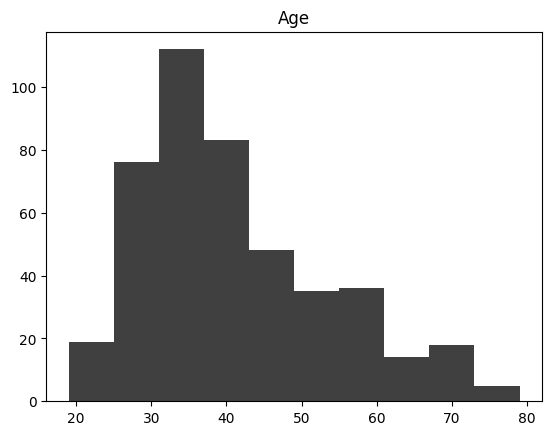

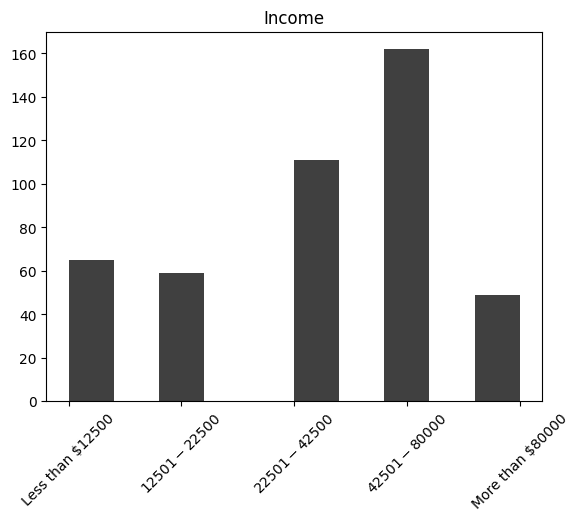

Mean News consumption bias for sample: 2.29 ( SD = 1.23 ; 1=Left & 3=Center & 5=Right)


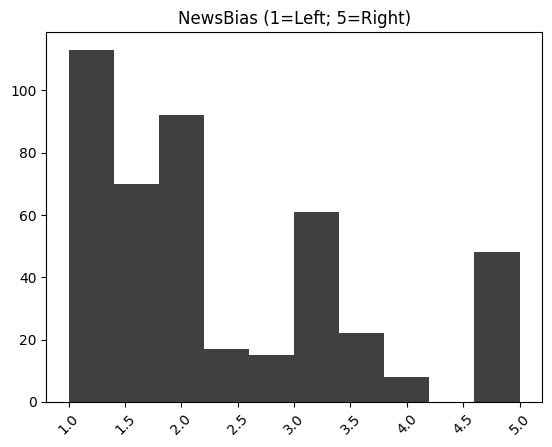

In [5]:
#@title Plot descriptive statistics
#TODO: Add breakdown by racial identity into the plots
#Report Gender breakdown
propFemale = (sum(Gender_nGnANB==1)/len(Gender_nGnANB))*100
propFemale = round(propFemale,2)
print('The sample is',propFemale, '% Female and', (100-propFemale),'% Male')

#Report racial breakdown
propBlack = (sum(blackCode_nGnANB==1)/len(blackCode_nGnANB))*100
propBlack = round(propBlack,2)
print('The sample is',propBlack, '% Black and', (100-propBlack),'% White')

# Plot age histograms
Age_mean = np.mean(Age_nGnANB)
Age_sd = np.std(Age_nGnANB)
print(f'Mean age for sample:', round(Age_mean,2), '( SD =', round(Age_sd,2), ')')
plt.hist(Age_nGnANB, alpha=0.75, color= 'k')
plt.title('Age')
plt.show()

# Plot Income histograms
customSort = {'Less than $12500':0, '$12501-$22500':1, '$22501-$42500':2, '$42501-$80000':3 ,'More than $80000':4}
IncPlot = Income_nGnANB.sort_values(key=lambda x: x.map(customSort))
plt.hist(IncPlot,
         alpha=0.75,
         color='k')
plt.title('Income')
plt.xticks(rotation = 45)
plt.show()

# Plot NewsBias histograms
Newsbias_mean = np.mean(NewsBias_nGnANB)
Newsbias_sd = np.std(NewsBias_nGnANB)

print(f'Mean News consumption bias for sample:', round(Newsbias_mean,2), '( SD =', round(Newsbias_sd,2), '; 1=Left & 3=Center & 5=Right)')
plt.hist(NewsBias_nGnANB.sort_values(axis=0),
         alpha=0.75,
         color='k')
plt.title('NewsBias (1=Left; 5=Right)')
plt.xticks(rotation = 45)
plt.show()

PRaM reliability for Total sample: 0.93
PRaM reliability for Black sample: 0.94
PRaM reliability for White sample: 0.92


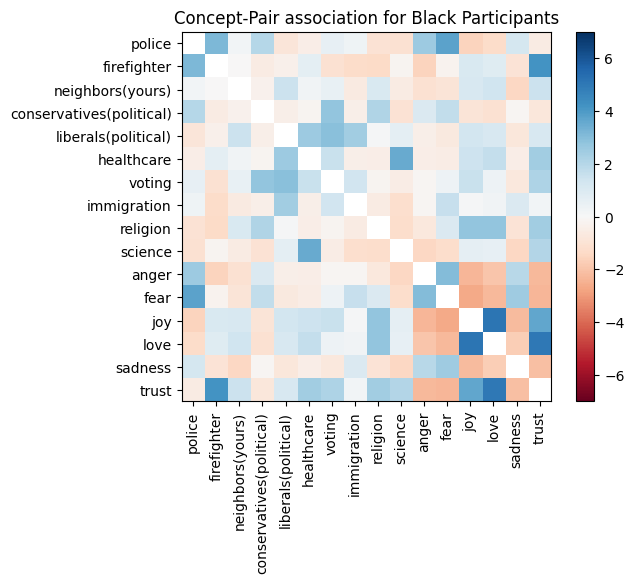

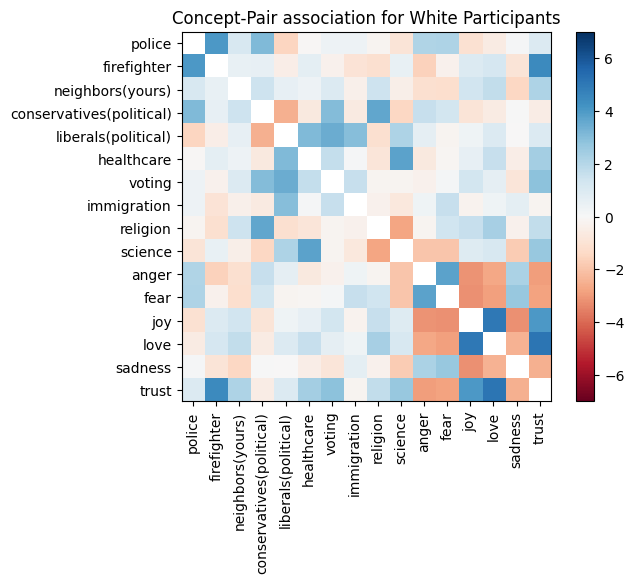

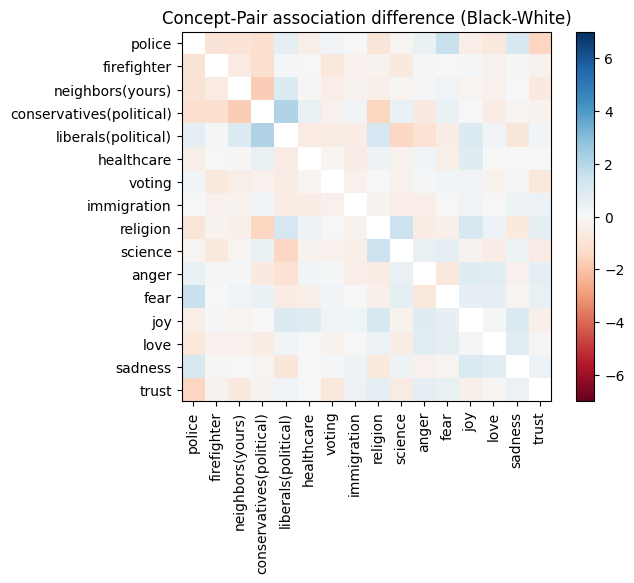

In [6]:
# @title Descriptive analysis of PRaM
#Subset data for Black and White Participants
bIndx_nGnANB = blackCode_nGnANB == 1
wIndx_nGnANB = blackCode_nGnANB == 0
bPRaM_nGnANB = PRaM_nGnANB[bIndx_nGnANB,:]
wPRaM_nGnANB = PRaM_nGnANB[wIndx_nGnANB,:]


# Average pair distance
avgDist = np.mean(PRaM_nGnANB, axis=0)
avgBDist = np.mean(bPRaM_nGnANB, axis=0)
avgWDist = np.mean(wPRaM_nGnANB, axis=0)

#Participant-wise normalization
PRaMz = stats.zscore(PRaM_nGnANB, axis=0)
bPRaMz = stats.zscore(bPRaM_nGnANB, axis=0)
wPRaMz = stats.zscore(wPRaM_nGnANB, axis=0)

#Convert to dataframes for Reliabiltiy calc
PRaMz = pd.DataFrame(PRaMz)
bPRaMz = pd.DataFrame(bPRaMz)
wPRaMz = pd.DataFrame(wPRaMz)

# Splithalf Reliability
perm = 10000
rhoPRaM = splitHalf_Reliability(PRaMz, perm)
rhobPRaM = splitHalf_Reliability(bPRaMz, perm)
rhowPRaM = splitHalf_Reliability(wPRaMz, perm)
print(f'PRaM reliability for Total sample:', round(rhoPRaM,2))
print(f'PRaM reliability for Black sample:', round(rhobPRaM,2))
print(f'PRaM reliability for White sample:', round(rhowPRaM,2))

# Generate distance matricies
bPRaM_Weights = weightedHeatmap(avgBDist, words,1, "Concept-Pair association for Black Participants"); # Compute association matrix for Black participants
wPRaM_Weights = weightedHeatmap(avgWDist, words,1, "Concept-Pair association for White Participants"); # Compute association matrix for White participants
diffPRaM_Weights = weightedHeatmap((avgBDist-avgWDist), words,1, "Concept-Pair association difference (Black-White)"); # Compute association matrix for Black-White differences

In [7]:
# @title Reset index and reshape for concatonation

#Income [Higher value means higher income bracket] [Note: This is coming later for plot formatting purposes]
i0Ind = Income_nGnANB.str.contains(pat = 'Less than $12500', case=False, regex=False)
i1Ind = Income_nGnANB.str.contains(pat = '$12501-$22500', case=False, regex=False)
i2Ind = Income_nGnANB.str.contains(pat = '$22501-$42500', case=False, regex=False)
i3Ind = Income_nGnANB.str.contains(pat = '$42501-$80000', case=False, regex=False)
i4Ind = Income_nGnANB.str.contains(pat = 'More than $80000', case=False, regex=False)
Income_nGnANB.loc[i0Ind] = 0
Income_nGnANB.loc[i1Ind] = 1
Income_nGnANB.loc[i2Ind] = 2
Income_nGnANB.loc[i3Ind] = 3
Income_nGnANB.loc[i4Ind] = 4
Income_nGnANB = Income_nGnANB


#Simplify variable  names
blackCoded = blackCode_nGnANB
femaleCoded = Gender_nGnANB
Income = Income_nGnANB
Age = Age_nGnANB
NewsBias = NewsBias_nGnANB

#Reset index for series (just in case)
#blackCoded = blackCoded.reset_index(drop=True)
#blackCoded = blackCoded.to_numpy() #convert series to array
femaleCoded = femaleCoded.reset_index(drop=True)
femaleCoded = femaleCoded.to_numpy() #convert series to array
Income = Income.reset_index(drop=True)
Income = Income.to_numpy()  #convert series to array
#Age = Age.reset_index(drop=True)
#Age = Age.to_numpy()  #convert series to array
NewsBias = NewsBias.reset_index(drop=True)
NewsBias = NewsBias.to_numpy()  #convert series to array

#Reshape for concatenation
blackCoded =  blackCoded.reshape(blackCoded.shape[0],1)
femaleCoded =  femaleCoded.reshape(femaleCoded.shape[0],1)
Income =  Income.reshape(Income.shape[0],1)
Age =  Age.reshape(Age.shape[0],1)
NewsBias = NewsBias.reshape(NewsBias.shape[0],1)

In [8]:
# @title Execute Permuted Multiple Regression model to measure Group differences
#Measure Word-Pair differences across group variables
#Permuted Multiple Regression model
#Y is 120 pair-distances (seperate models for each word pair)
#X contains all group breakdowns (dummy coded for discrete; sequentialized for ordinal variables)
#Permutation-testing (scramble Y) and FDR correction are also computed

#Group breakdown:
#----------------------------
#Race (Black identity is dummy coded)
#Gender (Female identity is dummy coded)
#Income (Coverted to an ordinal scale with higher values meaning greater income bracket)
#Age
#NewsBiasConsumption=Political
#[Location ideology (Live)] [CURRENTLY EXCLUDED]

#Use 10,000 iteration output (1 = yes; 0 = no)
use10000iter = 1

#Concatonate
X = np.concatenate((blackCoded, femaleCoded, Income, Age, NewsBias), axis=1)

#Y: Pair data
PRaM = PRaM_nGnANB

bObsPairsPRaM = []
pPairsPRaM = []
perm = 100
#Iterate through concept-pairs
for i in tqdm(range(len(PairLabel))):
    # Isolate pair data
    Y = PRaM[:,i]

    #Dummy coded linear regression
    #Compared against permuted distribution
    betaObs_PRaM, pval_PRaM, betaPerm1 = regPairDiff(X, Y, perm)

    #Update output
    bObsPairsPRaM.append(betaObs_PRaM)
    pPairsPRaM.append(pval_PRaM)
    #if i == 0:
    #  plt.hist(betaPerm1)

pPairsPRaM = pd.DataFrame(pPairsPRaM) #Convert to dataframe
bObsPairsPRaM = pd.DataFrame(bObsPairsPRaM)#Convert to dataframe

#Implement FDR correction
FDR_sig = []
import statsmodels as sm
for g in range(X.shape[1]):
  FDR = sm.stats.multitest.fdrcorrection(np.array(pPairsPRaM[g+1]), alpha=0.05, method='indep', is_sorted=False)#+1 is to account for constant in original model
  FDR_sig.append(FDR[0])
FDR_sig = pd.DataFrame(FDR_sig)

#Export data to CSV files
if use10000iter == 0:
  PrAM_final = pd.DataFrame(PRaM_nGnANB)
  FDR_sig.to_csv('FDRsig.csv')
  pPairsPRaM.to_csv('pValPairs.csv')
  bObsPairsPRaM.to_csv('bObsPairsPRaM.csv')
  PrAM_final.to_csv('PRaM_finalModel.csv')
elif use10000iter == 1:
  FDR_sig = pd.read_csv (path + 'analysis/FDRsig_10000.csv', header=0, index_col=0)
  pPairsPRaM = pd.read_csv (path + 'analysis/pValPairs_10000.csv', header=0, index_col=0)
  bObsPairsPRaM = pd.read_csv (path + 'analysis/bObsPairsPRaM_10000.csv', header=0, index_col=0)
  #PrAM_final = pd.read_csv (path + 'analysis/PRaM_finalModel_10000.csv', header=0, index_col=0)
  PrAM_final = pd.DataFrame(PRaM_nGnANB)

100%|██████████| 120/120 [00:03<00:00, 36.96it/s]


In [9]:
# @title Structure and Subset data for vizualization
#Isolate booleans of significant edges
sigEdges = FDR_sig.transpose()
sigEdges = sigEdges.reset_index(drop=True)
sigEdges_race = sigEdges[0]
sigEdges_gender = sigEdges[1]
sigEdges_income = sigEdges[2]
sigEdges_age = sigEdges[3]
sigEdges_newsBias = sigEdges[4]

#Subset
#Isolate Black and White samples and subset by sig edges
bfIdx = blackCoded == 1
wfIdx = blackCoded == 0
bfPRaM = PrAM_final[bfIdx]
wfPRaM = PrAM_final[wfIdx]
bfPRaM_sigEdges = bfPRaM.loc[:,sigEdges_race]
wfPRaM_sigEdges = wfPRaM.loc[:,sigEdges_race]
raceEdges = PairLabel[sigEdges_race]

#Seperate news bias consumption into left and right leaning
leftNewsIdx = NewsBias < 3
rightNewsIdx = NewsBias > 3
lfPRaM = PrAM_final[leftNewsIdx]
rtPRaM = PrAM_final[rightNewsIdx]
lfPRaM_sigEdges = lfPRaM.loc[:,sigEdges_newsBias]
rtPRaM_sigEdges = rtPRaM.loc[:,sigEdges_newsBias]
newsEdges = PairLabel[sigEdges_newsBias]

#Compute subset means and SEM
bfsePRaM_mean = bfPRaM_sigEdges.mean(axis=0)
wfsePRaM_mean = wfPRaM_sigEdges.mean(axis=0)
bfsePRaM_SEM = np.std(bfPRaM_sigEdges, axis=0)/np.sqrt(bfPRaM_sigEdges.shape[0])
wfsePRaM_SEM = np.std(wfPRaM_sigEdges, axis=0)/np.sqrt(wfPRaM_sigEdges.shape[0])

lfsePRaM_mean = lfPRaM_sigEdges.mean(axis=0)
rtsePRaM_mean = rtPRaM_sigEdges.mean(axis=0)
lfsePRaM_SEM = np.std(lfPRaM_sigEdges, axis=0)/np.sqrt(lfPRaM_sigEdges.shape[0])
rtsePRaM_SEM = np.std(rtPRaM_sigEdges, axis=0)/np.sqrt(rtPRaM_sigEdges.shape[0])



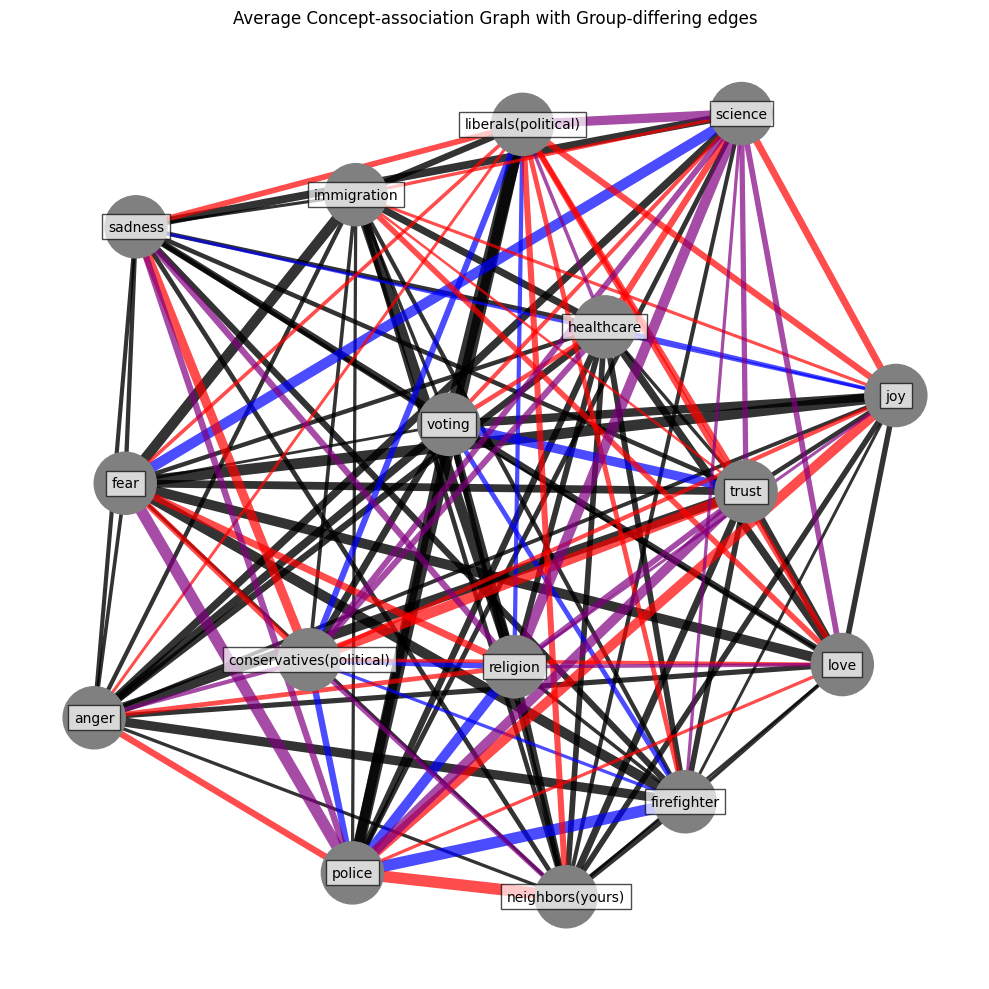

In [15]:
# @title Figure 1: Compute average graph across the full sample and highlight race-differing, news-differing, and both race- and news- differing edges

#For Figure 1: Compute average graph across the full sample and highlight race-differing, news-differing, and both race- and news- differing edges
PrAM_final = PrAM_final
PrAM_mean = PrAM_final.mean(axis=0)
PrAM_meanEdge = (PrAM_mean - min(PrAM_mean)) / (max(PrAM_mean) - min(PrAM_mean)) #adjust range to be between 0 and 1
PrAM_meanEdge = PrAM_meanEdge.reset_index(drop=True)
#PrAM_meanEdge = (PrAM_meanEdge + 0.01) *10 #add 0.1 to account for 0 and multiply edges by constant to aid with vizualization
conceptPairs = pd.Series(combinations_list)

#Identify unique and overlapping edges between race and news
sigEdge_RNoverlap = np.logical_and(sigEdges_race, sigEdges_newsBias)
sigEdge_RaceUnq = np.logical_and(sigEdges_race, ~sigEdge_RNoverlap)
sigEdge_NewsUnq = np.logical_and(sigEdges_newsBias, ~sigEdge_RNoverlap)
sigEdges = np.logical_or(sigEdge_RaceUnq, sigEdge_NewsUnq)
sigEdges = np.logical_or(sigEdges, sigEdge_RNoverlap)

#Draw Graph for average participant
G = nx.Graph()
for e in range(len(conceptPairs)):
  G.add_edge(conceptPairs[e][0], conceptPairs[e][1], weight = round(PrAM_meanEdge[e],3))

pos = nx.spring_layout(G, iterations=10000, seed=9)  # positions for all nodes - seed for reproducibility

# Format nodes
PRaM_graphCentrality = round(pd.Series(nx.degree_centrality(G)),2) #make size of nodes proportional to centrality
nx.draw_networkx_nodes(G, pos, node_size=(PRaM_graphCentrality*2000), node_color = 'grey')
label_options = {"ec": "k", "fc": "white", "alpha": 0.7}
nx.draw_networkx_labels(G, pos, font_size=10, bbox=label_options)

# Format edges
EdgeList = [(u,v) for (u,v) in G.edges]
EdgeList_RaceUnq = list(compress(EdgeList, sigEdge_RaceUnq))
EdgeList_NewsUnq = list(compress(EdgeList, sigEdge_NewsUnq))
EdgeList_RaceNewsOverlap = list(compress(EdgeList, sigEdge_RNoverlap))
EdgeList_nonSig = list(compress(EdgeList, ~sigEdges))

# edge width is proportional weight
edgewidth = [G.get_edge_data(u, v)["weight"] for u, v in G.edges()]
edgewidth = [(x+0.01) * 10 for x in edgewidth] #add 0.01 to account for 0 and multiply edges by constant to aid with vizualization

#Draw edges
nx.draw_networkx_edges(G, pos, edgelist=EdgeList_nonSig, width=edgewidth, alpha = 0.8) #draw all edges
nx.draw_networkx_edges(G, pos, edgelist=EdgeList_RaceUnq, width=edgewidth, alpha = 0.7, edge_color="b") #draw race differing edges
nx.draw_networkx_edges(G, pos, edgelist=EdgeList_NewsUnq, width=edgewidth, alpha=0.7, edge_color="r") #draw news differing edges
nx.draw_networkx_edges(G, pos, edgelist=EdgeList_RaceNewsOverlap, width=edgewidth, alpha=0.7, edge_color="purple") #draw news differing edges

#Set figure parameters
ax = plt.gca()
plt.axis("off")
plt.title('Average Concept-association Graph with Group-differing edges')
plt.rcParams["figure.figsize"] = [10, 10]
plt.rcParams["figure.autolayout"] = True
plt.show()

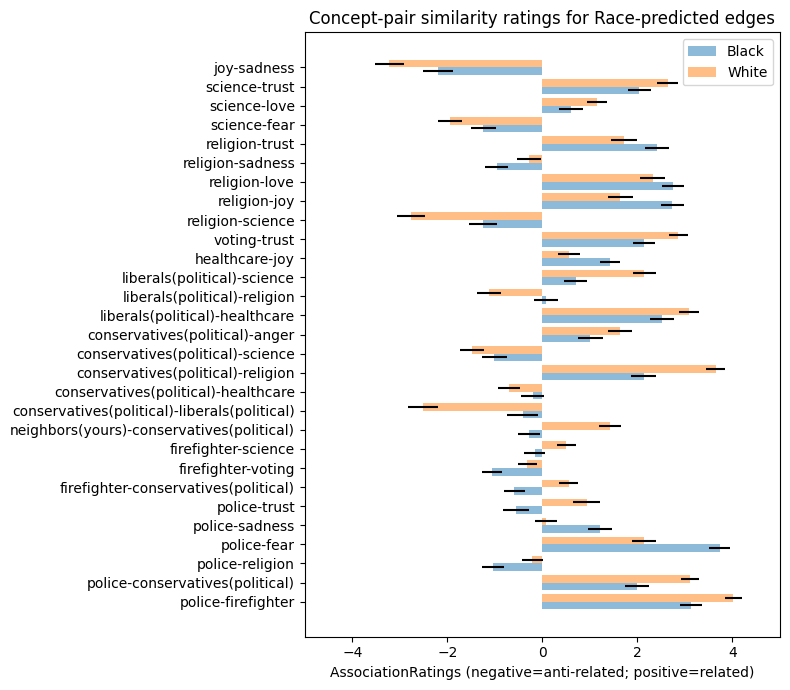

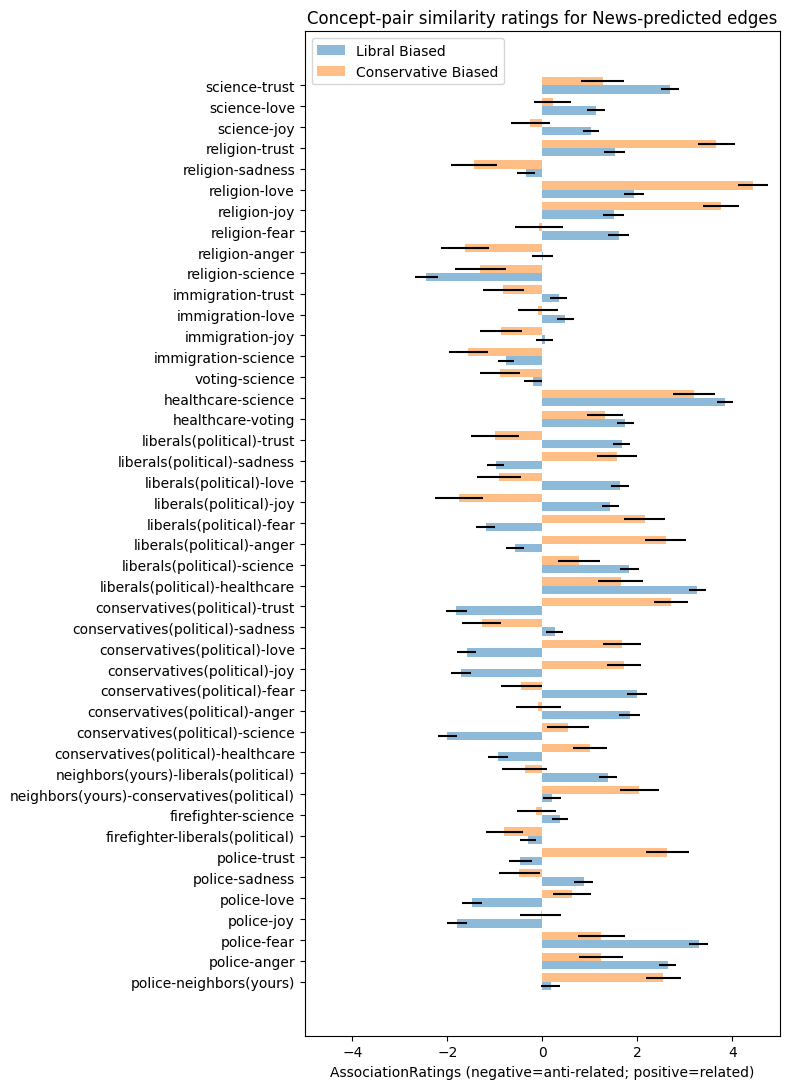

In [11]:
# @title Vizualize Concept-pair Length Comparison for Significant Edges (This will also serve as the panel for Figure 2)

# Set bar width
bar_width = 0.4

# Plot grouped bar chart with error bars
plt.rcParams["figure.figsize"] = [8, 7.0]
plt.rcParams["figure.autolayout"] = True
r1_race = np.arange(len(bfsePRaM_mean))
r2_race = [x + bar_width for x in r1_race]
fig, ax_race = plt.subplots()
ax_race.barh(r1_race, bfsePRaM_mean, xerr=bfsePRaM_SEM, height=bar_width, alpha=0.5, label='Black')
ax_race.barh(r2_race, wfsePRaM_mean, xerr=wfsePRaM_SEM, height=bar_width, alpha=0.5, label='White')
plt.title('Concept-pair similarity ratings for Race-predicted edges')
ax_race.set_yticks([r + bar_width / 2 for r in range(len(bfsePRaM_mean))])
ax_race.set_yticklabels(raceEdges[0].values.tolist(), rotation=0)
#ax_race.grid(which = "minor", axis='y', linestyle = "dashed")
#ax_race.minorticks_on()
ax_race.set_xlabel('AssociationRatings (negative=anti-related; positive=related)')
ax_race.legend()
plt.xlim([-5, 5])
plt.show()


# Plot grouped bar chart with error bars
plt.rcParams["figure.figsize"] = [8, 11.0]
plt.rcParams["figure.autolayout"] = True
r1_news = np.arange(len(lfsePRaM_mean))
r2_news = [x + bar_width for x in r1_news]
fig, ax_news = plt.subplots()
ax_news.barh(r1_news, lfsePRaM_mean, xerr=lfsePRaM_SEM, height=bar_width, alpha=0.5, label='Libral Biased')
ax_news.barh(r2_news, rtsePRaM_mean, xerr=rtsePRaM_SEM, height=bar_width, alpha=0.5, label='Conservative Biased')
plt.title('Concept-pair similarity ratings for News-predicted edges')
ax_news.set_yticks([r + bar_width / 2 for r in range(len(lfsePRaM_mean))])
ax_news.set_yticklabels(newsEdges[0].values.tolist(), rotation=0)
ax_news.set_xlabel('AssociationRatings (negative=anti-related; positive=related)')
ax_news.legend()
plt.xlim([-5, 5])
plt.show()

100%|██████████| 10000/10000 [03:06<00:00, 53.56it/s]


The r between Black identity and convervative news consumption is: -0.195 (p= [0.0] )


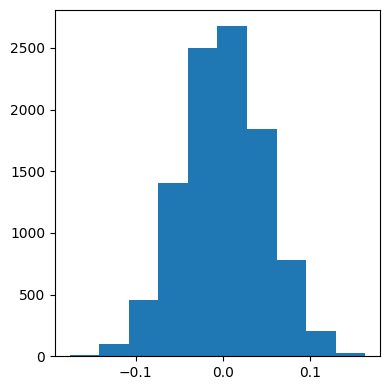

In [12]:
# @title Establish correlational relationship between News Consumption and Racial Identity
#Establish relationship between News and Black Identity
blackCoded_Cor = pd.DataFrame(blackCoded)
NewsBias_Cor = pd.DataFrame(NewsBias)
obsCorr_BN = blackCoded_Cor.corrwith(NewsBias_Cor, method='pearson')


# Generate the permutations
perm = 10000
pComb = ccbi_randperm(NewsBias_Cor.shape[0],perm)

rPermDist = []

for p in tqdm(range(perm)):
  pCombi = pComb.astype(int)
  yPerm = NewsBias_Cor.loc[pCombi[p,:]]
  yPerm = yPerm.reset_index(drop=True)
  rPerm = blackCoded_Cor.corrwith(yPerm, method='pearson')
  rPermDist.append(rPerm)
rPermDist = pd.DataFrame(rPermDist)

pval =[]
if obsCorr_BN[0] > 0:
  nBbeyond =  len(np.where(np.array(rPermDist) > obsCorr_BN[0])[0])
  pb = nBbeyond/perm
  pval.append(pb)
elif obsCorr_BN[0] < 0:
  nBbeyond = len([x for x in np.array(rPermDist) if x < obsCorr_BN[0]])
  pb = nBbeyond/perm
  pval.append(pb)

else:
  raise ValueError('observed beta is exactly equal to 0')

plt.rcParams["figure.figsize"] = [4, 4]
plt.rcParams["figure.autolayout"] = True
plt.hist(rPermDist)
print('The r between Black identity and convervative news consumption is:', round(obsCorr_BN[0],3), '(p=',pval,')')

In [13]:
# @title Mediation analysis measuring effect of Black Identity (X) on Pair-distances (Yi) through News Consumption Bias (m)

#Use 10,000 iteration output (1 = yes; 0 = no)
use10000iter = 1

#Subset Mediation analysis by sig edges
PRaM_sigNewsEdges = PrAM_final.loc[:,sigEdges_newsBias]

#X: Black Identity
X_med = blackCoded.reshape(blackCoded.shape[0]) #adjust shape to fit

#m: News Consumption Bias
m_med = NewsBias

#Y: Pair data
Y_med = PRaM_sigNewsEdges.to_numpy()

#TRY FOR SINGLE PAIR BEFORE RUNNING FOR ALL 120

#Loop through each pair and compute a permutation scrambling Y
ObsPairsPRaM_med = pd.DataFrame({'TotEff':[],'MedEff':[], 'DirEff':[], 'SumEff':[], 'SobelT':[]})
pPairsPRaM_med = pd.DataFrame({'Totpval':[],'Medpval':[], 'Dirpval':[], 'Sumpval':[], 'SobelTpval':[]})
perm = 100
#Iterate through concept-pairs
for i in tqdm(range(Y_med.shape[1])):
  # Isolate pair data
  yi = Y_med[:,i]

  #Dummy coded linear regression
  #Compared against permuted distribution
  medObs_PRaM, pval_PRaM = mediationPerm(X_med, m_med, yi, perm)

  #Update output
  ObsPairsPRaM_med = pd.concat([ObsPairsPRaM_med,medObs_PRaM],ignore_index=True)
  pPairsPRaM_med = pd.concat([pPairsPRaM_med, pval_PRaM],ignore_index=True)

#Implement FDR correction
FDR_sigMed = []
import statsmodels as sm
for (columnName, columnData) in pPairsPRaM_med.iteritems():
  FDR = sm.stats.multitest.fdrcorrection(pPairsPRaM_med[columnName], alpha=0.05, method='indep', is_sorted=False)
  FDR_sigMed.append(FDR[0])
FDR_sigMed = pd.DataFrame(FDR_sigMed)

#Export data to CSV files
if use10000iter == 0:
  PrAM_save = pd.DataFrame(PRaM_nGnANB)
  FDR_sigMed.to_csv('FDRsigMed.csv')
  pPairsPRaM_med.to_csv('pPairsPRaM_med.csv')
  ObsPairsPRaM_med.to_csv('ObsPairsPRaM_med.csv')
  PrAM_save.to_csv('PRaM_finalModel_med.csv')
elif use10000iter == 1:
  FDR_sigMed = pd.read_csv (path + 'analysis/FDRsigMed_10000.csv', header=0, index_col=0)
  pPairsPRaM_med = pd.read_csv (path + 'analysis/pPairsPRaM_med_10000.csv', header=0, index_col=0)
  ObsPairsPRaM_med = pd.read_csv (path + 'analysis/ObsPairsPRaM_med_10000.csv', header=0, index_col=0)
  #PrAM_final = pd.read_csv (path + 'analysis/PRaM_finalModel_med_10000.csv', header=0, index_col=0)
  PrAM_final = pd.DataFrame(PRaM_nGnANB)

100%|██████████| 44/44 [00:16<00:00,  2.70it/s]
<ipython-input-13-069d2442ce8d>:40: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for (columnName, columnData) in pPairsPRaM_med.iteritems():


<ipython-input-69-5d437250ff79>:23: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  sigDirectUnq = pd.Series(list(compress(sigDirect, ~sigMediation)))


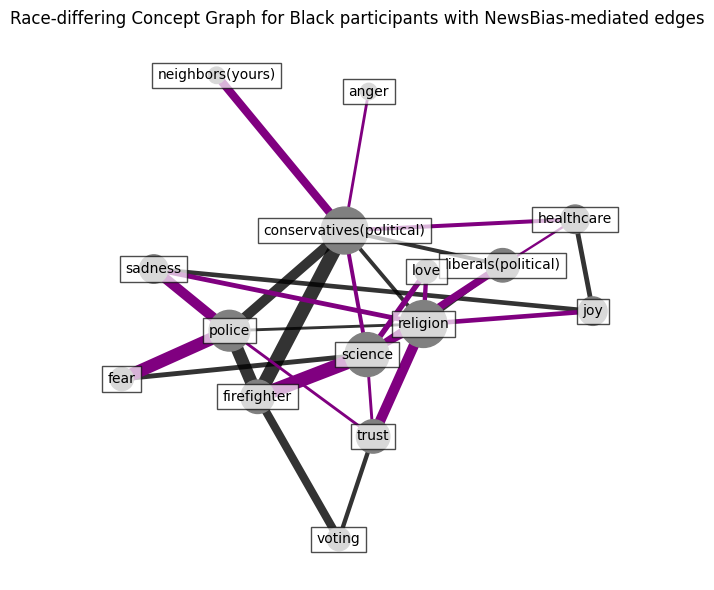

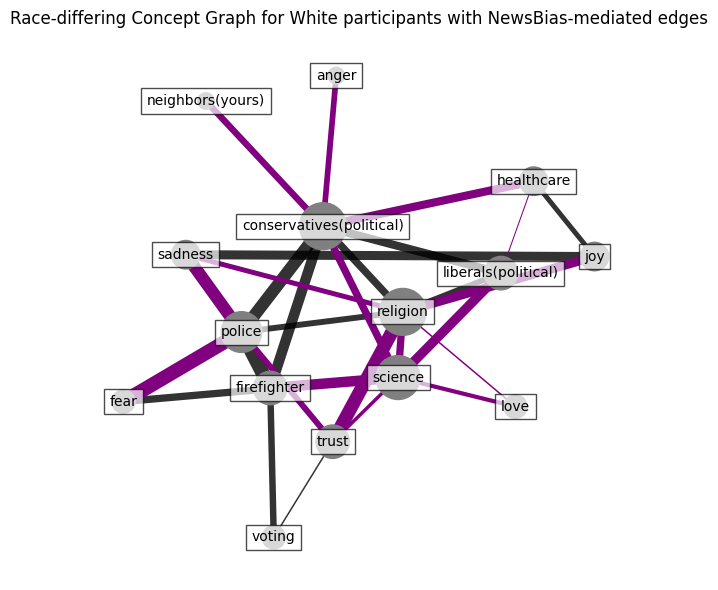

In [69]:
# @title Figure 3: Race-differings graphs and News-mediated edges

#Compute graphs for sig race edges [From above vizualization cell]
bfPRaM = PrAM_final[bfIdx]
wfPRaM = PrAM_final[wfIdx]
bfPRaM = bfPRaM.loc[:,sigEdges_race]
wfPRaM = wfPRaM.loc[:,sigEdges_race]
bfPRaM_mean = bfPRaM.mean(axis=0) #take the mean across participants
wfPRaM_mean = wfPRaM.mean(axis=0) #take the mean across participants
bfPRaM_mean_grph = (bfPRaM_mean - min(bfPRaM_mean)) / (max(bfPRaM_mean) - min(bfPRaM_mean))
wfPRaM_mean_grph = (wfPRaM_mean - min(wfPRaM_mean)) / (max(wfPRaM_mean) - min(wfPRaM_mean))
bfPRaM_mean_grph = bfPRaM_mean_grph.reset_index(drop=True)
wfPRaM_mean_grph = wfPRaM_mean_grph.reset_index(drop=True)

conceptPairs_race = pd.Series(list(compress(conceptPairs, sigEdges_race)))
conceptPairs_race = conceptPairs_race.reset_index(drop=True)

#Get Booleans of Med and Direct effects
FDR_sigMedT = FDR_sigMed.transpose()
sigMediation = FDR_sigMedT[1]
sigDirect = FDR_sigMedT[2]
sigDirMed = pd.Series(list(compress(sigDirect, sigMediation)))
sigDirectUnq = pd.Series(list(compress(sigDirect, ~sigMediation)))
sigMediationUnq = pd.Series(list(compress(~sigDirMed, sigMediation)))

#Get full-set indicies of dir, med, and dir/med effects
newsSigIndex = [i for i, x in enumerate(sigEdges_newsBias) if x]
newsSigIndex_dir = list(compress(newsSigIndex, sigDirect))
newsSigIndex_med = list(compress(newsSigIndex, sigMediation))
newsSigIndex_dirMed = list(compress(newsSigIndex, sigDirMed))
newsSigIndex_dirUnq = list(compress(newsSigIndex, sigDirectUnq))
newsSigIndex_medUnq = list(compress(newsSigIndex, sigMediationUnq))

conceptPairs_newsDir = conceptPairs[newsSigIndex_dir]
conceptPairs_newsMed = conceptPairs[newsSigIndex_med]
conceptPairs_newsDirMedUnq = conceptPairs[newsSigIndex_dirMed]
conceptPairs_newsDirUnq = conceptPairs[newsSigIndex_dirUnq]
conceptPairs_newsMedUnq = conceptPairs[newsSigIndex_medUnq]

conceptPairs_newsDir = [(u,v) for (u,v) in conceptPairs_newsDir]
conceptPairs_newsMed = [(u,v) for (u,v) in conceptPairs_newsMed]
conceptPairs_newsDirMedUnq = [(u,v) for (u,v) in conceptPairs_newsDirMedUnq]
conceptPairs_newsDirUnq = [(u,v) for (u,v) in conceptPairs_newsDirUnq]
conceptPairs_newsMedUnq = [(u,v) for (u,v) in conceptPairs_newsMedUnq]

raceSigIndex = [i for i, x in enumerate(sigEdges_race) if x]
raceSigUnqEdges = [i for i in raceSigIndex if i not in newsSigIndex]
conceptPairs_unqRace = conceptPairs[raceSigUnqEdges]
conceptPairs_unqRace = [(u,v) for (u,v) in conceptPairs_unqRace]

#Draw Race-differing Graph for Black participants
Grb = nx.Graph()
for e in range(len(conceptPairs_race)):
  Grb.add_edge(conceptPairs_race[e][0], conceptPairs_race[e][1], weight = round(bfPRaM_mean_grph[e],3))

pos = nx.spring_layout(Grb, iterations=10000, seed=9)  # positions for all nodes - seed for reproducibility

# Format nodes
PRaMRace_graphCentrality = round(pd.Series(nx.degree_centrality(Grb)),2) #make size of nodes proportional to centrality
nx.draw_networkx_nodes(Grb, pos, node_size=(PRaMRace_graphCentrality*2000), node_color = 'grey')
label_options = {"ec": "k", "fc": "white", "alpha": 0.7}
nx.draw_networkx_labels(Grb, pos, font_size=10, bbox=label_options)

#Subset full-set edge list with those that are race-differing
EdgeList = [(u,v) for (u,v) in Grb.edges]
EdgeList_RaceUnq = [(u,v) for (u,v) in EdgeList if (u,v) in conceptPairs_unqRace or (v,u) in conceptPairs_unqRace]
EdgeList_NewsDirUnq = [(u,v) for (u,v) in EdgeList if (u,v) in conceptPairs_newsDirUnq or (v,u) in conceptPairs_newsDirUnq]
EdgeList_NewsMedUnq = [(u,v) for (u,v) in EdgeList if (u,v) in conceptPairs_newsMedUnq or (v,u) in conceptPairs_newsMedUnq]
EdgeList_NewsMedNDirEffUnq = [(u,v) for (u,v) in EdgeList if (u,v) in conceptPairs_newsDirMedUnq or (v,u) in conceptPairs_newsDirMedUnq]

# edge width is proportional weight
edgewidth = [Grb.get_edge_data(u, v)["weight"] for u, v in Grb.edges()]
edgewidth = [(x+0.01) * 10 for x in edgewidth] #add 0.01 to account for 0 and multiply edges by constant to aid with vizualization

#Draw edges
nx.draw_networkx_edges(Grb, pos, edgelist=EdgeList_RaceUnq, width=edgewidth, alpha = 0.8) #Not mediated
nx.draw_networkx_edges(Grb, pos, edgelist=EdgeList_NewsDirUnq, width=edgewidth, alpha = 0.9, edge_color="r") #direct but not mediated
nx.draw_networkx_edges(Grb, pos, edgelist=EdgeList_NewsMedUnq, width=edgewidth, alpha = 0.7, edge_color="b") #Mediated and not direct
nx.draw_networkx_edges(Grb, pos, edgelist=EdgeList_NewsMedNDirEffUnq, width=edgewidth, alpha = 1, edge_color="purple") #mediated and direct

#Set figure parameters
ax = plt.gca()
plt.axis("off")
plt.title('Race-differing Concept Graph for Black participants with NewsBias-mediated edges')
plt.rcParams["figure.figsize"] = [6, 6]
plt.rcParams["figure.autolayout"] = True
plt.show()



#Draw Race-differing Graph for White participants
Grw = nx.Graph()
for e in range(len(conceptPairs_race)):
  Grw.add_edge(conceptPairs_race[e][0], conceptPairs_race[e][1], weight = round(wfPRaM_mean_grph[e],3))

pos = nx.spring_layout(Grw, iterations=10000, seed=9)  # positions for all nodes - seed for reproducibility

# Format nodes
PRaMRace_graphCentrality = round(pd.Series(nx.degree_centrality(Grw)),2) #make size of nodes proportional to centrality
nx.draw_networkx_nodes(Grw, pos, node_size=(PRaMRace_graphCentrality*2000), node_color = 'grey')
label_options = {"ec": "k", "fc": "white", "alpha": 0.7}
nx.draw_networkx_labels(Grw, pos, font_size=10, bbox=label_options)

#Subset full-set edge list with those that are race-differing
EdgeList = [(u,v) for (u,v) in Grw.edges]
EdgeList_RaceUnq = [(u,v) for (u,v) in EdgeList if (u,v) in conceptPairs_unqRace or (v,u) in conceptPairs_unqRace]
EdgeList_NewsDirUnq = [(u,v) for (u,v) in EdgeList if (u,v) in conceptPairs_newsDirUnq or (v,u) in conceptPairs_newsDirUnq]
EdgeList_NewsMedUnq = [(u,v) for (u,v) in EdgeList if (u,v) in conceptPairs_newsMedUnq or (v,u) in conceptPairs_newsMedUnq]
EdgeList_NewsMedNDirEffUnq = [(u,v) for (u,v) in EdgeList if (u,v) in conceptPairs_newsDirMedUnq or (v,u) in conceptPairs_newsDirMedUnq]

# edge width is proportional weight
edgewidth = [Grw.get_edge_data(u, v)["weight"] for u, v in Grw.edges()]
edgewidth = [(x+0.01) * 10 for x in edgewidth] #add 0.01 to account for 0 and multiply edges by constant to aid with vizualization

#Draw edges
nx.draw_networkx_edges(Grw, pos, edgelist=EdgeList_RaceUnq, width=edgewidth, alpha = 0.8) #Not mediated
nx.draw_networkx_edges(Grw, pos, edgelist=EdgeList_NewsDirUnq, width=edgewidth, alpha = 0.9, edge_color="r") #direct but not mediated
nx.draw_networkx_edges(Grw, pos, edgelist=EdgeList_NewsMedUnq, width=edgewidth, alpha = 0.7, edge_color="b") #Mediated and not direct
nx.draw_networkx_edges(Grw, pos, edgelist=EdgeList_NewsMedNDirEffUnq, width=edgewidth, alpha = 1, edge_color="purple") #mediated and direct

#Set figure parameters
ax = plt.gca()
plt.axis("off")
plt.title('Race-differing Concept Graph for White participants with NewsBias-mediated edges')
plt.rcParams["figure.figsize"] = [6, 6]
plt.rcParams["figure.autolayout"] = True
plt.show()


In [ ]:
# @title [Discontinuted]

#For Figure 1: Compute average graph across the full sample and highlight race-differing, news-differing, and both race- and news- differing edges
PrAM_final = PrAM_final
PrAM_sigRaceEdges = PrAM_final.loc[:,sigEdges_race]
PrAM_sigRaceEdges_mean = PrAM_sigRaceEdges.mean(axis=0)
PrAM_sigRaceEdges_graph_mean = (PrAM_sigRaceEdges_mean - min(PrAM_sigRaceEdges_mean)) / (max(PrAM_sigRaceEdges_mean) - min(PrAM_sigRaceEdges_mean))
PrAM_sigRaceEdges_graph_mean = PrAM_sigRaceEdges_graph_mean.reset_index(drop=True)

#Compute graphs for sig race edges [From above vizualization cell]
bfPRaM = PrAM_final[bfIdx]
wfPRaM = PrAM_final[wfIdx]
bfPRaM_sigEdges = bfPRaM.loc[:,sigEdges_race]
wfPRaM_sigEdges = wfPRaM.loc[:,sigEdges_race]
bfPRaM_sigEdges_mean = bfPRaM_sigEdges.mean(axis=0) #take the mean across participants
wfPRaM_sigEdges_mean = wfPRaM_sigEdges.mean(axis=0) #take the mean across participants
bfPRaM_sigEdges_grph_mean = (bfPRaM_sigEdges_mean - min(bfPRaM_sigEdges_mean)) / (max(bfPRaM_sigEdges_mean) - min(bfPRaM_sigEdges_mean))
wfPRaM_sigEdges_grph_mean = (wfPRaM_sigEdges_mean - min(wfPRaM_sigEdges_mean)) / (max(wfPRaM_sigEdges_mean) - min(wfPRaM_sigEdges_mean))
bfPRaM_sigEdges_grph_mean = bfPRaM_sigEdges_grph_mean.reset_index(drop=True)
wfPRaM_sigEdges_grph_mean = wfPRaM_sigEdges_grph_mean.reset_index(drop=True)

#Compute graphs for sig news edges [From above vizualization cell]
lfPRaM = PrAM_final[leftNewsIdx]
rtPRaM = PrAM_final[rightNewsIdx]
lfPRaM_sigEdges = lfPRaM.loc[:,sigEdges_newsBias]
rtPRaM_sigEdges = rtPRaM.loc[:,sigEdges_newsBias]
lfPRaM_sigEdges_mean = lfPRaM_sigEdges.mean(axis=0) #take the mean across participants
rtPRaM_sigEdges_mean = rtPRaM_sigEdges.mean(axis=0) #take the mean across participants
lfPRaM_sigEdges_grph_mean = (lfPRaM_sigEdges_mean - min(lfPRaM_sigEdges_mean)) / (max(lfPRaM_sigEdges_mean) - min(lfPRaM_sigEdges_mean))
rtPRaM_sigEdges_grph_mean = (rtPRaM_sigEdges_mean - min(rtPRaM_sigEdges_mean)) / (max(rtPRaM_sigEdges_mean) - min(rtPRaM_sigEdges_mean))
lfPRaM_sigEdges_grph_mean = lfPRaM_sigEdges_grph_mean.reset_index(drop=True)
rtPRaM_sigEdges_grph_mean = rtPRaM_sigEdges_grph_mean.reset_index(drop=True)

#Subset concept pairs by sig edges
conceptPairs = pd.Series(combinations_list)
conceptPairsRace = conceptPairs[sigEdges_race]
conceptPairsNews = conceptPairs[sigEdges_newsBias]
conceptPairsRace = conceptPairsRace.reset_index(drop=True)
conceptPairsNews = conceptPairsNews.reset_index(drop=True)

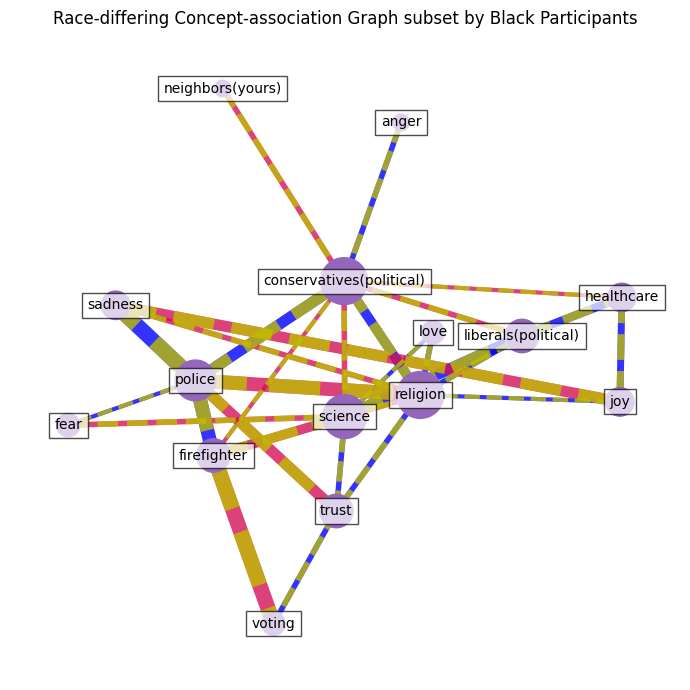

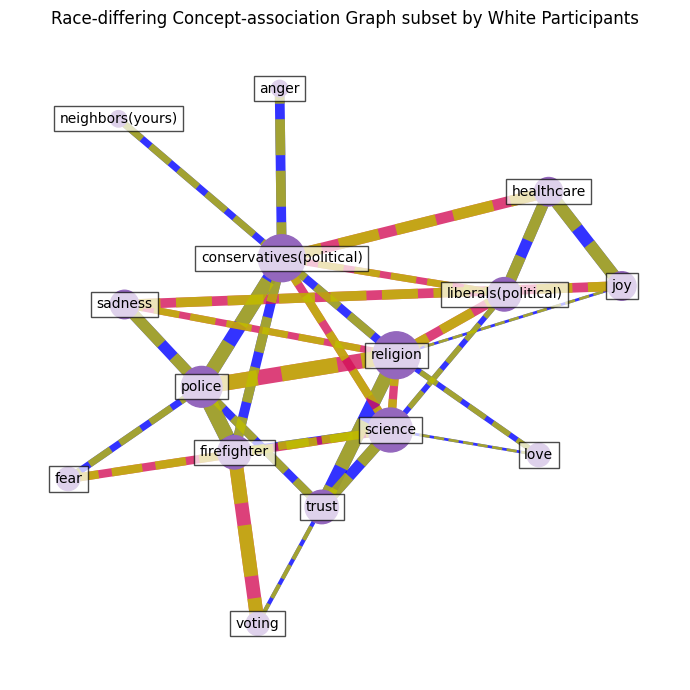

In [ ]:
# @title Draw graph of significant edges across race [THIS IS BEING CONVERTED TO THE DESIRED GRAPH IN THE PAPER]
#Draw graph of significant edges across race

#Draw Graph for Black participants
Grb = nx.Graph()
for e in range(len(conceptPairsRace)):
  Grb.add_edge(conceptPairsRace[e][0], conceptPairsRace[e][1], weight = round(bfPRaM_sigEdges_grph_mean[e],1))

pos = nx.spring_layout(Grb, iterations=10000, seed=9)  # positions for all nodes - seed for reproducibility

# Format nodes
bfPRaM_graphCentrality = round(pd.Series(nx.degree_centrality(Grb)),2) #make size of nodes proportional to centrality
nx.draw_networkx_nodes(Grb, pos, node_size=(bfPRaM_graphCentrality*2000), node_color = 'tab:purple')
label_options = {"ec": "k", "fc": "white", "alpha": 0.7}
nx.draw_networkx_labels(Grb, pos, font_size=10, bbox=label_options)

# Format edges
elarge = [(u, v) for (u, v, d) in Grb.edges(data=True) if d["weight"] > (0 - min(bfPRaM_sigEdges_mean)) / (max(bfPRaM_sigEdges_mean) - min(bfPRaM_sigEdges_mean))]
esmall = [(u, v) for (u, v, d) in Grb.edges(data=True) if d["weight"] <= (0 - min(bfPRaM_sigEdges_mean)) / (max(bfPRaM_sigEdges_mean) - min(bfPRaM_sigEdges_mean))]

# edge width is proportional weight
edgewidth = [Grb.get_edge_data(u, v)["weight"] for u, v in Grb.edges()]
edgewidth = [(x+0.1) * 10 for x in edgewidth]

#Draw edges
nx.draw_networkx_edges(Grb, pos, edgelist=elarge, width=edgewidth, alpha = 0.8, edge_color="b") #specify attractor edges
nx.draw_networkx_edges(Grb, pos, edgelist=esmall, width=edgewidth, alpha=0.8, edge_color="#D41159") #specify deflector edges [, style="dashed"]

#Add mediation edges [ONCE YOU CREATE THE APPROPTIRATE LIST IN CELL ABOVE REPLAE edgelist]
nx.draw_networkx_edges(Grb, pos, edgelist=elarge, width=edgewidth, alpha = 0.8, edge_color="y", style="dashed")
nx.draw_networkx_edges(Grb, pos, edgelist=esmall, width=edgewidth, alpha=0.8, edge_color="y", style="dashed") #specify deflector edges

#Set figure parameters
ax = plt.gca()
plt.axis("off")
plt.title('Race-differing Concept-association Graph subset by Black Participants')
plt.rcParams["figure.figsize"] = [7, 7]
plt.rcParams["figure.autolayout"] = True
plt.show()



#Draw Graph for White participants
Grw = nx.Graph()
for e in range(len(conceptPairsRace)):
  Grw.add_edge(conceptPairsRace[e][0], conceptPairsRace[e][1], weight = round(wfPRaM_sigEdges_grph_mean[e],1))

pos = nx.spring_layout(Grw, iterations=10000, seed=9)  # positions for all nodes - seed for reproducibility

# Format nodes
wfPRaM_graphCentrality = round(pd.Series(nx.degree_centrality(Grw)),2) #make size of nodes proportional to centrality
nx.draw_networkx_nodes(Grw, pos, node_size=(wfPRaM_graphCentrality*2000), node_color = 'tab:purple')
label_options = {"ec": "k", "fc": "white", "alpha": 0.7}
nx.draw_networkx_labels(Grw, pos, font_size=10, bbox=label_options)

# Format edges
elarge = [(u, v) for (u, v, d) in Grw.edges(data=True) if d["weight"] > (0 - min(wfPRaM_sigEdges_mean)) / (max(wfPRaM_sigEdges_mean) - min(wfPRaM_sigEdges_mean))]
esmall = [(u, v) for (u, v, d) in Grw.edges(data=True) if d["weight"] <= (0 - min(wfPRaM_sigEdges_mean)) / (max(wfPRaM_sigEdges_mean) - min(wfPRaM_sigEdges_mean))]

# edge width is proportional weight
edgewidth = [Grw.get_edge_data(u, v)["weight"] for u, v in Grw.edges()]
edgewidth = [(x+0.1) * 10 for x in edgewidth]

#Draw edges
nx.draw_networkx_edges(Grw, pos, edgelist=elarge, width=edgewidth, alpha = 0.8, edge_color="b") #specify attractor edges
nx.draw_networkx_edges(Grw, pos, edgelist=esmall, width=edgewidth, alpha=0.8, edge_color="#D41159") #specify deflector edges [, style="dashed"]

#Add mediation edges [ONCE YOU CREATE THE APPROPTIRATE LIST IN CELL ABOVE REPLAE edgelist]
nx.draw_networkx_edges(Grw, pos, edgelist=elarge, width=edgewidth, alpha = 0.8, edge_color="y", style="dashed")
nx.draw_networkx_edges(Grw, pos, edgelist=esmall, width=edgewidth, alpha=0.8, edge_color="y", style="dashed") #specify deflector edges

#Set figure parameters
ax = plt.gca()
plt.axis("off")
plt.title('Race-differing Concept-association Graph subset by White Participants')
plt.rcParams["figure.figsize"] = [7, 7]
#plt.rcParams["figure.autolayout"] = True
plt.show()

In [ ]:
elarge

[('police', 'firefighter'),
 ('police', 'conservatives(political)'),
 ('police', 'fear'),
 ('police', 'sadness'),
 ('police', 'trust'),
 ('firefighter', 'conservatives(political)'),
 ('firefighter', 'science'),
 ('conservatives(political)', 'neighbors(yours)'),
 ('conservatives(political)', 'religion'),
 ('conservatives(political)', 'anger'),
 ('religion', 'joy'),
 ('religion', 'love'),
 ('religion', 'trust'),
 ('trust', 'voting'),
 ('trust', 'science'),
 ('science', 'liberals(political)'),
 ('science', 'love'),
 ('liberals(political)', 'healthcare'),
 ('healthcare', 'joy')]

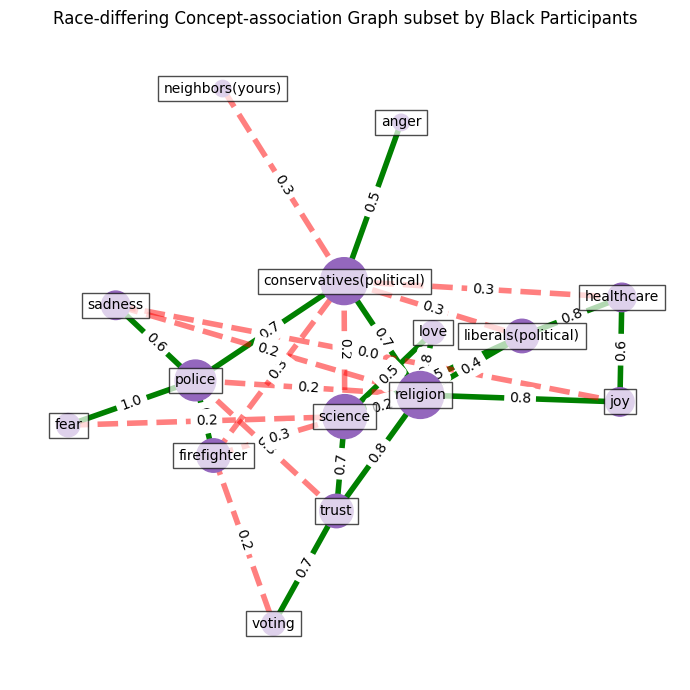

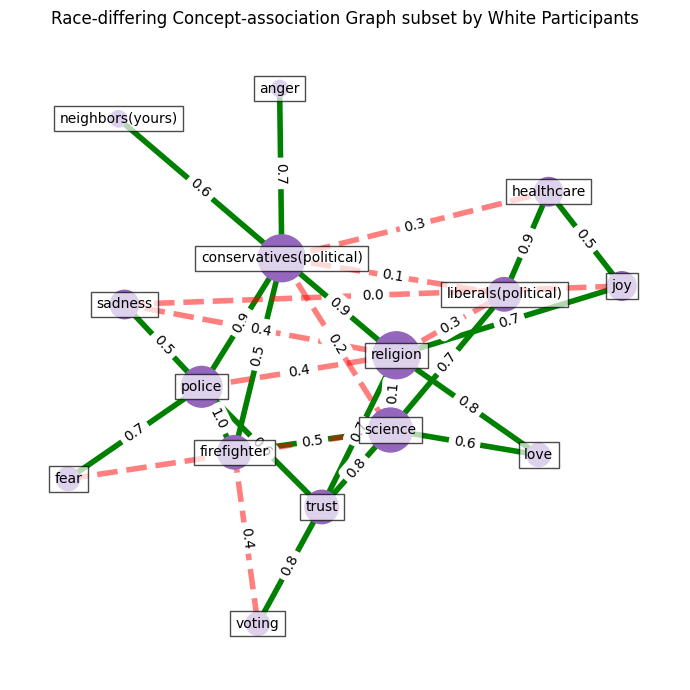

In [ ]:
# @title Draw graph of significant edges across race
#Draw graph of significant edges across race

#Draw Graph for Black participants
Grb = nx.Graph()
for e in range(len(conceptPairsRace)):
  Grb.add_edge(conceptPairsRace[e][0], conceptPairsRace[e][1], weight = round(bfPRaM_sigEdges_grph_mean[e],1))

pos = nx.spring_layout(Grb, iterations=10000, seed=9)  # positions for all nodes - seed for reproducibility

# Format nodes
bfPRaM_graphCentrality = round(pd.Series(nx.degree_centrality(Grb)),2) #make size of nodes proportional to centrality
nx.draw_networkx_nodes(Grb, pos, node_size=(bfPRaM_graphCentrality*2000), node_color = 'tab:purple')
label_options = {"ec": "k", "fc": "white", "alpha": 0.7}
nx.draw_networkx_labels(Grb, pos, font_size=10, bbox=label_options)

# Format edges
elarge = [(u, v) for (u, v, d) in Grb.edges(data=True) if d["weight"] > (0 - min(bfPRaM_sigEdges_mean)) / (max(bfPRaM_sigEdges_mean) - min(bfPRaM_sigEdges_mean))]
esmall = [(u, v) for (u, v, d) in Grb.edges(data=True) if d["weight"] <= (0 - min(bfPRaM_sigEdges_mean)) / (max(bfPRaM_sigEdges_mean) - min(bfPRaM_sigEdges_mean))]
nx.draw_networkx_edges(Grb, pos, edgelist=elarge, edge_color="g", width=4) #specify attractor edges
nx.draw_networkx_edges(Grb, pos, edgelist=esmall, width=4, alpha=0.5, edge_color="r", style="dashed") #specify deflector edges
edge_labels = nx.get_edge_attributes(Grb, "weight") #add edge labels
nx.draw_networkx_edge_labels(Grb, pos, edge_labels) #add labels

#Set figure parameters
ax = plt.gca()
plt.axis("off")
plt.title('Race-differing Concept-association Graph subset by Black Participants')
plt.rcParams["figure.figsize"] = [7, 7]
plt.rcParams["figure.autolayout"] = True
plt.show()



#Draw Graph for White participants
Grw = nx.Graph()
for e in range(len(conceptPairsRace)):
  Grw.add_edge(conceptPairsRace[e][0], conceptPairsRace[e][1], weight = round(wfPRaM_sigEdges_grph_mean[e],1))

pos = nx.spring_layout(Grw, iterations=10000, seed=9)  # positions for all nodes - seed for reproducibility

# Format nodes
wfPRaM_graphCentrality = round(pd.Series(nx.degree_centrality(Grw)),2) #make size of nodes proportional to centrality
nx.draw_networkx_nodes(Grw, pos, node_size=(wfPRaM_graphCentrality*2000), node_color = 'tab:purple')
label_options = {"ec": "k", "fc": "white", "alpha": 0.7}
nx.draw_networkx_labels(Grw, pos, font_size=10, bbox=label_options)

# Format edges
elarge = [(u, v) for (u, v, d) in Grw.edges(data=True) if d["weight"] > (0 - min(wfPRaM_sigEdges_mean)) / (max(wfPRaM_sigEdges_mean) - min(wfPRaM_sigEdges_mean))]
esmall = [(u, v) for (u, v, d) in Grw.edges(data=True) if d["weight"] <= (0 - min(wfPRaM_sigEdges_mean)) / (max(wfPRaM_sigEdges_mean) - min(wfPRaM_sigEdges_mean))]
nx.draw_networkx_edges(Grw, pos, edgelist=elarge, edge_color="g", width=4) #specify attractor edges
nx.draw_networkx_edges(Grw, pos, edgelist=esmall, width=4, alpha=0.5, edge_color="r", style="dashed") #specify deflector edges
edge_labels = nx.get_edge_attributes(Grw, "weight") #add edge labels
nx.draw_networkx_edge_labels(Grw, pos, edge_labels) #add labels

#Set figure parameters
ax = plt.gca()
plt.axis("off")
plt.title('Race-differing Concept-association Graph subset by White Participants')
plt.rcParams["figure.figsize"] = [7, 7]
#plt.rcParams["figure.autolayout"] = True
plt.show()

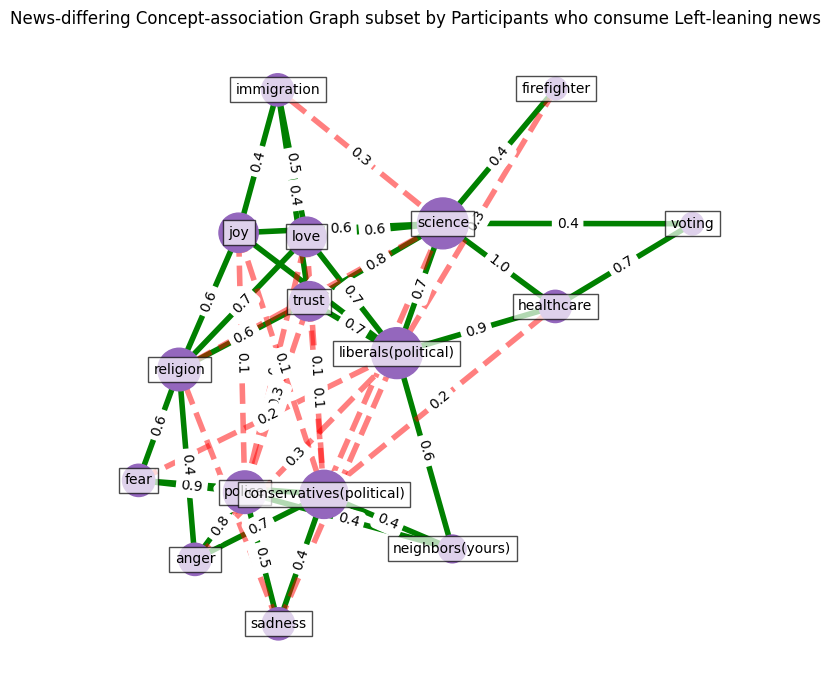

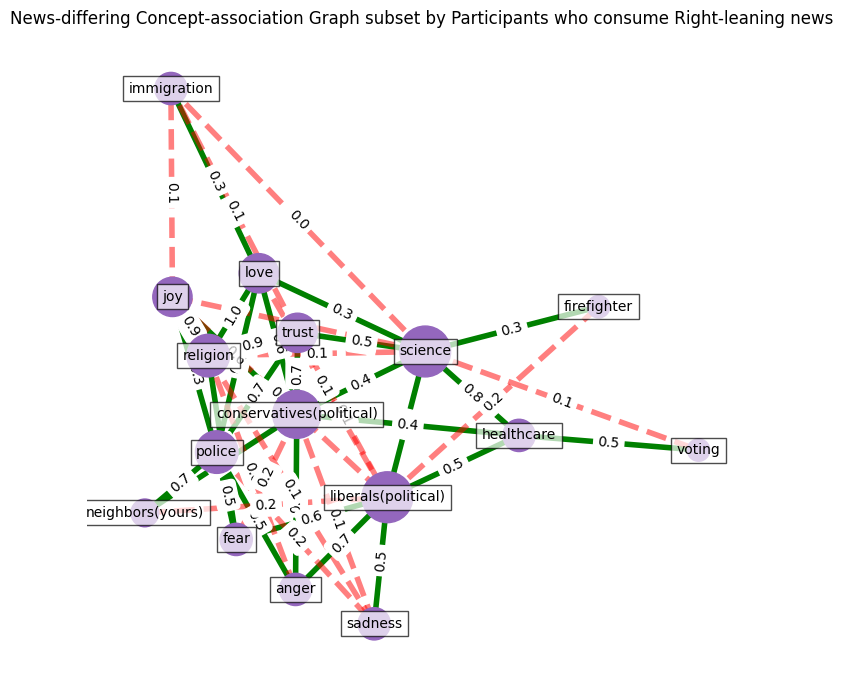

In [ ]:
# @title Draw graph of significant edges across news consumption
#Draw graph of significant edges across bias in news consumption

#Draw Graph for participants who consume left-leaning news media
Gnl = nx.Graph()
for e in range(len(conceptPairsNews)):
  Gnl.add_edge(conceptPairsNews[e][0], conceptPairsNews[e][1], weight = round(lfPRaM_sigEdges_grph_mean[e],1))

pos = nx.spring_layout(Gnl, iterations=10000, seed=9)  # positions for all nodes - seed for reproducibility

# Format nodes
lfPRaM_graphCentrality = round(pd.Series(nx.degree_centrality(Gnl)),2) #make size of nodes proportional to centrality
nx.draw_networkx_nodes(Gnl, pos, node_size=(lfPRaM_graphCentrality*2000), node_color = 'tab:purple')
label_options = {"ec": "k", "fc": "white", "alpha": 0.7}
nx.draw_networkx_labels(Gnl, pos, font_size=10, bbox=label_options)

# Format edges
elarge = [(u, v) for (u, v, d) in Gnl.edges(data=True) if d["weight"] > (0 - min(lfPRaM_sigEdges_mean)) / (max(lfPRaM_sigEdges_mean) - min(lfPRaM_sigEdges_mean))]
esmall = [(u, v) for (u, v, d) in Gnl.edges(data=True) if d["weight"] <= (0 - min(lfPRaM_sigEdges_mean)) / (max(lfPRaM_sigEdges_mean) - min(lfPRaM_sigEdges_mean))]
nx.draw_networkx_edges(Gnl, pos, edgelist=elarge, edge_color="g", width=4) #specify attractor edges
nx.draw_networkx_edges(Gnl, pos, edgelist=esmall, width=4, alpha=0.5, edge_color="r", style="dashed") #specify deflector edges
edge_labels = nx.get_edge_attributes(Gnl, "weight") #add edge labels
nx.draw_networkx_edge_labels(Gnl, pos, edge_labels) #add labels

#Set figure parameters
ax = plt.gca()
plt.axis("off")
plt.title('News-differing Concept-association Graph subset by Participants who consume Left-leaning news')
plt.rcParams["figure.figsize"] = [7, 7]
plt.rcParams["figure.autolayout"] = True
plt.show()



#Draw Graph for participants who consume right-leaning news media
Gnr = nx.Graph()
for e in range(len(conceptPairsNews)):
  Gnr.add_edge(conceptPairsNews[e][0], conceptPairsNews[e][1], weight = round(rtPRaM_sigEdges_grph_mean[e],1))

pos = nx.spring_layout(Gnr, iterations=10000, seed=9)  # positions for all nodes - seed for reproducibility

# Format nodes
rfPRaM_graphCentrality = round(pd.Series(nx.degree_centrality(Gnr)),2) #make size of nodes proportional to centrality
nx.draw_networkx_nodes(Gnr, pos, node_size=(rfPRaM_graphCentrality*2000), node_color = 'tab:purple')
label_options = {"ec": "k", "fc": "white", "alpha": 0.7}
nx.draw_networkx_labels(Gnr, pos, font_size=10, bbox=label_options)

# Format edges
elarge = [(u, v) for (u, v, d) in Gnr.edges(data=True) if d["weight"] > (0 - min(rtPRaM_sigEdges_mean)) / (max(rtPRaM_sigEdges_mean) - min(rtPRaM_sigEdges_mean))]
esmall = [(u, v) for (u, v, d) in Gnr.edges(data=True) if d["weight"] <= (0 - min(rtPRaM_sigEdges_mean)) / (max(rtPRaM_sigEdges_mean) - min(rtPRaM_sigEdges_mean))]
nx.draw_networkx_edges(Gnr, pos, edgelist=elarge, edge_color="g", width=4) #specify attractor edges
nx.draw_networkx_edges(Gnr, pos, edgelist=esmall, width=4, alpha=0.5, edge_color="r", style="dashed") #specify deflector edges
edge_labels = nx.get_edge_attributes(Gnr, "weight") #add edge labels
nx.draw_networkx_edge_labels(Gnr, pos, edge_labels) #add labels

#Set figure parameters
ax = plt.gca()
plt.axis("off")
plt.title('News-differing Concept-association Graph subset by Participants who consume Right-leaning news')
plt.rcParams["figure.figsize"] = [7, 7]
plt.show()

In [ ]:
#Create random graph by scrambing associations to statistical test

#Paper:
#Story simplication: hub concept and mediation
#Take home message: evidence that information biases concept geometries across groups
#News provides the frame/context



#Packet:
# 1/3 past
# 1/3 geo and deicsion
# 1/3 Future
#NOTE: Mention graduated 22

